## Bank digital solution clustering project
### Preinterpretation Workflow 
1. Import and EDA
2. Dataset Stadardization 
3. Exploratory KMeans (k from 3 to 15) on the *entire dataset* and select an optimal cluster number based on elbow chart / silhouette score
#### Add in PCA to remove multicollinearity and improve within-cluster compactness along with between-cluster distinctiveness 
4. Categorize variables into *active (dynamic, behavioral + psychographic ones)* vs *supplementary(static, geographical and demographic ones)* and run PCA on active category, ideally reducing to 2 to 5 dimensions. 
5. Run kmeans with optimal cluster number on pca_transformed data and produce the cluster labels 
6. Compare original clustering results vs pca cluster results via (1) silhouette score (2)label counts distribution (3)intersection of label assignment
7. Decide which cluster labels to go with, the original ones or the pca ones  

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
df = pd.read_csv("Data/StrattonAEBankingCRM.csv")
df.shape
# 10750 records and 28 variables

(10750, 28)

In [3]:
# no missing values. all data types are appropriate
# no time series data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10750 entries, 0 to 10749
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    10750 non-null  int64  
 1   Income                 10750 non-null  int64  
 2   HouseholdSize          10750 non-null  int64  
 3   CityAreaSize           10750 non-null  int64  
 4   MeanCityIncome         10750 non-null  int64  
 5   MeanCityHousePrize     10750 non-null  int64  
 6   MeanCityHouseHoldSize  10750 non-null  int64  
 7   MeanCitySqFtPrice      10750 non-null  int64  
 8   NumberCars             10750 non-null  int64  
 9   InternetTrafficVolume  10750 non-null  int64  
 10  MortageVolume          10750 non-null  int64  
 11  AccountSpending        10750 non-null  float64
 12  CreditCardSpending     10750 non-null  float64
 13  HelpHotlineTime        10750 non-null  float64
 14  CustomerSince          10750 non-null  int64  
 15  Gr

In [4]:
# get a brief statistical summary 
# everything is ready to be input into clustering algorithms
df.describe()

,Age,Income,HouseholdSize,CityAreaSize,MeanCityIncome,MeanCityHousePrize,MeanCityHouseHoldSize,MeanCitySqFtPrice,NumberCars,InternetTrafficVolume,...,NASDAQInvest,USAXSFundInvest,BranchVisits,AppLogins,ATMVisits,TimeOnlineBanking,ServiceFees,SocialMediaInter,Bitcoins,NFTs
count,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,1.075000e+04,10750.000000,10750.000000,10750.000000,10750.000000,...,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000,10750.000000
mean,35.156651,84699.601953,2.809674,372196.129023,163706.020279,9.425050e+05,3.022977,5318.269023,1.383814,67.565023,...,1828.480162,761.645087,3.912558,55.704558,4.928093,113.878607,40.938245,19.028837,0.193681,3.317395
std,13.542091,49337.110399,1.325119,228010.188666,64581.642188,7.136861e+05,1.338834,2394.522297,0.925567,33.096996,...,1447.337174,836.464178,3.219362,34.641660,2.324207,59.183105,31.086657,17.050131,0.222972,2.691006
min,18.000000,35202.000000,1.000000,61613.000000,35372.000000,1.250110e+05,1.000000,1871.000000,0.000000,6.000000,...,228.352966,69.947903,0.000000,1.000000,0.000000,22.769131,0.134308,0.000000,0.000000,0.000000
25%,23.000000,42803.250000,2.000000,121703.750000,116252.750000,4.448165e+05,2.000000,2627.000000,1.000000,45.000000,...,401.400337,149.795783,2.000000,18.000000,3.000000,69.281909,17.844189,5.000000,0.000500,1.000000
50%,30.000000,71268.000000,3.000000,450100.000000,140457.500000,6.146005e+05,3.000000,5778.500000,1.000000,60.000000,...,1498.098994,313.824135,3.000000,64.000000,5.000000,88.256085,27.238595,16.000000,0.099800,3.000000
75%,45.000000,125870.000000,4.000000,459418.000000,235000.000000,1.849915e+06,4.000000,6741.000000,2.000000,86.000000,...,3056.049762,1060.232555,5.000000,82.000000,7.000000,152.915443,50.165175,31.000000,0.400500,4.000000
max,74.000000,181863.000000,8.000000,708729.000000,286996.000000,1.850000e+06,8.000000,9886.000000,4.000000,118.000000,...,4532.364575,3396.609135,20.000000,130.000000,11.000000,232.214599,124.261270,60.000000,0.601400,12.000000


In [5]:
# standardize the data before everything is ready to be input into clustering algorithms
df_scaled = pd.DataFrame()
for col in df.columns:
    col_mean = df[col].mean()
    col_std = df[col].std()
    df_scaled[col] = (df[col] - col_mean) / col_std

df_scaled.head()

,Age,Income,HouseholdSize,CityAreaSize,MeanCityIncome,MeanCityHousePrize,MeanCityHouseHoldSize,MeanCitySqFtPrice,NumberCars,InternetTrafficVolume,...,NASDAQInvest,USAXSFundInvest,BranchVisits,AppLogins,ATMVisits,TimeOnlineBanking,ServiceFees,SocialMediaInter,Bitcoins,NFTs
0,0.357651,-0.102896,-0.611020,0.361782,-1.130941,1.271530,-0.017162,-0.628630,0.665739,-0.289000,...,-0.235336,-0.341791,-0.283459,-1.319352,1.751956,-0.715234,0.028780,0.467513,-0.854281,-0.489555
1,0.136120,-0.265188,1.652928,0.352041,-0.107833,1.270998,1.476676,-0.022664,0.665739,-0.953713,...,-0.224097,-0.324445,0.027161,-1.059550,1.321701,-0.789776,0.361219,0.350212,-0.852039,-0.861163
2,2.646810,-0.125172,-1.365670,0.370150,-1.722193,1.271494,-0.017162,-0.799019,-0.414680,-0.319214,...,-0.226951,-0.354912,-0.283459,-1.203885,1.321701,-0.928952,0.440463,0.526164,-0.807639,-0.861163
3,1.317621,-0.299199,0.143629,0.370150,-0.701190,1.270582,0.729757,-1.326891,-1.495099,0.103785,...,-0.229408,-0.327095,0.027161,-1.203885,1.321701,-0.894146,0.027946,0.878067,-0.861457,-0.861163
4,0.357651,-0.211922,-1.365670,0.350019,-1.973920,1.270505,2.223594,-1.318956,-0.414680,-0.863070,...,-0.226887,-0.372199,-0.283459,-1.146151,1.751956,-0.789491,0.520921,0.878067,-0.834996,-1.232771


#### Exploratory KMeans

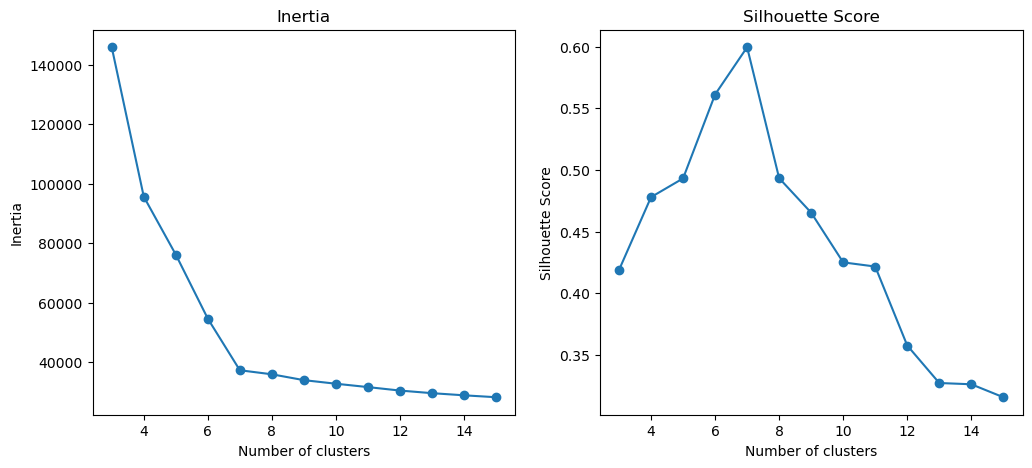

In [6]:
# exploratory kmeans with clusters from 3 to 15
# with inertia plot/silhouette score plot to help decide the optimal number of clusters

inertia = []
silhouette = []

for k in range(3,16):
    kmeans = KMeans(n_clusters=k, n_init='auto',random_state=42)
    model = kmeans.fit(df_scaled)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(df_scaled,model.labels_,metric='euclidean', sample_size=None))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(3,16), inertia, marker='o')
plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(range(3,16), silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()



In [7]:
# Numerical comparison  of inertia and silhouette scores 
# n = 7 seems to be the best number of clusters
metrics_df = pd.DataFrame(
    {'Number of clusters': range(3,16),
     'Inertia': inertia,
     'Silhouette_score':silhouette}
)

# silhouette score is the highest at ~0.599 when n=7
metrics_df.sort_values('Silhouette_score',ascending=False).head(1)


,Number of clusters,Inertia,Silhouette_score
4,7,37276.153849,0.599674


In [8]:
# rerun kmeans with n=7, and look at label counts distribution, roughly even with cluster 1 over 2500  
kmeans7 = KMeans(n_clusters=7, n_init='auto',random_state=42)
kmeans7.fit(df_scaled)
df_scaled['cluster'] = kmeans7.labels_
df_scaled['cluster'].value_counts()

cluster
1    2500
5    1500
0    1500
3    1500
4    1500
6    1250
2    1000
Name: count, dtype: int64

#### KMeans on PCA transformed data

In [9]:
active_vars = [
    'InternetTrafficVolume','AccountSpending','CreditCardSpending','HelpHotlineTime',
    'GrocerySpending','StockVolume','CreditVolume','BranchVisits','AppLogins',
    'ATMVisits','TimeOnlineBanking','ServiceFees','NASDAQInvest','USAXSFundInvest',
    'SocialMediaInter','Bitcoins','NFTs'
]

supplementary_vars = [
    'Age','Income','HouseholdSize','NumberCars','MortageVolume','CustomerSince',
    'CityAreaSize','MeanCityIncome','MeanCityHousePrize','MeanCityHouseHoldSize',
    'MeanCitySqFtPrice']

In [10]:
# Divide variables into active vs supplementary ones and run PCA (expecting ~85% variance captured)
# Turns out we only need 4 PCA components to achieve this goal, aka dimension reduced from 17 to 4
X_active = df_scaled[active_vars]

pca = PCA(n_components=0.85,random_state=42)
X_active_pca = pca.fit_transform(X_active)
X_active_pca.shape 

(10750, 4)

In [11]:
# Store PCA loading matrix for interpretation 
loadings = pd.DataFrame(pca.components_, columns=X_active.columns, index=['pc1', 'pc2','pc3','pc4'])
loadings

,InternetTrafficVolume,AccountSpending,CreditCardSpending,HelpHotlineTime,GrocerySpending,StockVolume,CreditVolume,BranchVisits,AppLogins,ATMVisits,TimeOnlineBanking,ServiceFees,NASDAQInvest,USAXSFundInvest,SocialMediaInter,Bitcoins,NFTs
pc1,0.321451,-0.186602,-0.272733,-0.184838,-0.163518,0.215825,0.270503,-0.236497,0.306537,0.012121,0.291528,0.239271,0.157780,0.165446,0.299369,0.273444,0.312839
pc2,-0.088134,0.368618,0.190858,0.345534,0.390357,0.357846,-0.091383,0.248760,0.036115,-0.223663,0.093372,0.264104,0.400535,0.071468,0.060843,0.183379,0.131168
pc3,0.058062,0.098562,0.102410,-0.107122,0.146104,-0.019936,0.152689,-0.058986,-0.285882,0.669283,-0.323452,0.305807,0.221984,0.067508,0.290945,-0.222077,0.028376
pc4,-0.016387,-0.125225,0.242864,-0.018327,-0.008518,0.013830,-0.436813,-0.189859,-0.105701,0.151965,0.202995,-0.065731,-0.028394,0.768668,-0.073832,0.108595,-0.094446


In [12]:
# fit the kmeans7 model on the pca components 
kmeans_pca = KMeans(n_clusters=7, n_init='auto',random_state=42)
kmeans_pca.fit(X_active_pca)
df_scaled['cluster_pca'] = kmeans_pca.labels_
# roughly similar cluster distribution as before
df_scaled['cluster_pca'].value_counts()

cluster_pca
1    2500
5    1500
0    1500
3    1500
4    1500
6    1250
2    1000
Name: count, dtype: int64

#### Compare PCA_based clustering results vs. original clustering results

In [13]:
# with PCA transformation, silhouette score significantly improves from ~0.599 to 0.809
silhouette_score(X_active_pca, kmeans_pca.labels_,metric='euclidean', sample_size=None)

0.8089339784248942

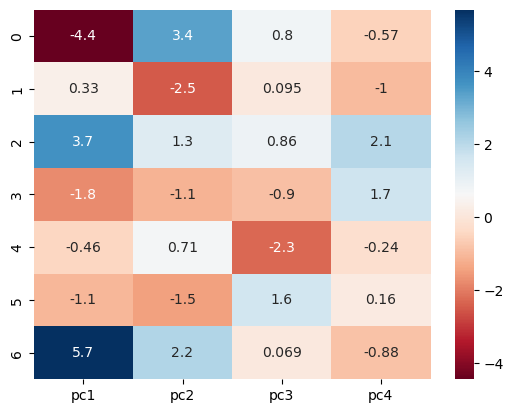

In [14]:
# check the heatmap of the cluster centers after PCA transformation. 
# We can observe more distinct patterns.
sns.heatmap(pd.DataFrame(kmeans_pca.cluster_centers_,columns=loadings.index),annot=True, cmap='RdBu');

In [15]:
# check the overlap of the two clustering results
# We confirm that the two clustering results are similar. Decide to go with pca results, since they are more robust
pd.crosstab(df_scaled['cluster'],df_scaled['cluster_pca'])

cluster_pca,0,1,2,3,4,5,6
cluster,,,,,,,
0,1500,0,0,0,0,0,0
1,0,2500,0,0,0,0,0
2,0,0,1000,0,0,0,0
3,0,0,0,1500,0,0,0
4,0,0,0,0,1500,0,0
5,0,0,0,0,0,1500,0
6,0,0,0,0,0,0,1250


### Interpretation workflow
1. Generate 2D PCA Scatter Plot ('pca1' and 'pca2') to view cluster separation 
2. Interpret each PCA Component (Select top 4 variables (absolute values) via Loadings)
3. Cluster profiling for each active variable from the original raw dataset, to get a sense of the characteristics of each cluster
4. Radar chart for cluster profiles based on 10 distinguising variables in PCA loadings

* original dataset: df
* original scaled dataset: df_scaled
* pca_transformed features: X_active_pca
* pca_based cluster labels: df_scaled['clusters_pca'], df['clusters_pca]

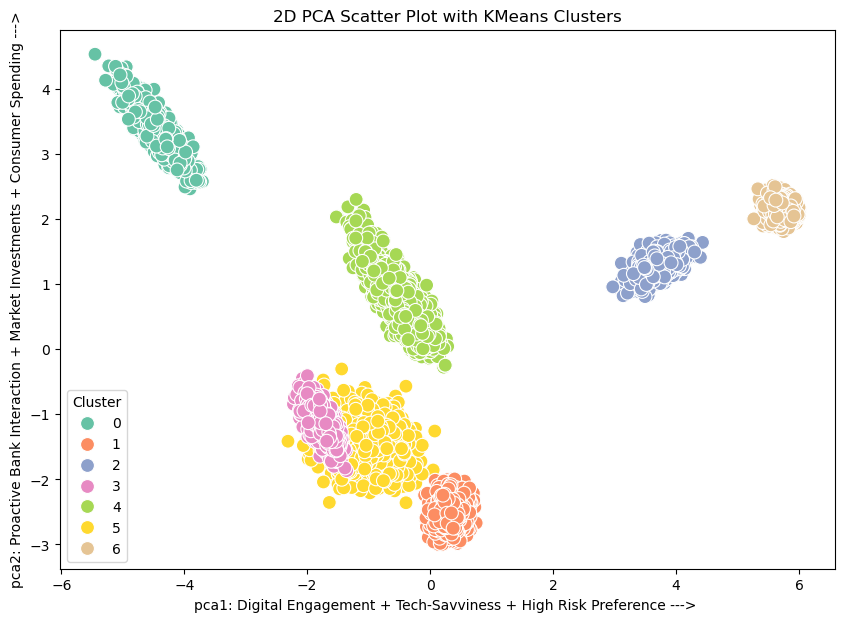

In [16]:
# 2D PCA Scatter Plot (Cluster Separation / Visualize the first 2 PCA components)
# cluster 3 and 5 seem overlap, yet it doesn’t automatically mean the clustering is wrong
# as we are only visualizing the first two pca components
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_active_pca[:,0], y=X_active_pca[:,1], hue=df_scaled['cluster_pca'], palette='Set2', s=100)
plt.title('2D PCA Scatter Plot with KMeans Clusters')
plt.xlabel('pca1: Digital Engagement + Tech-Savviness + High Risk Preference ---> ')
plt.ylabel('pca2: Proactive Bank Interaction + Market Investments + Consumer Spending --->')
plt.legend(title='Cluster')
plt.show()

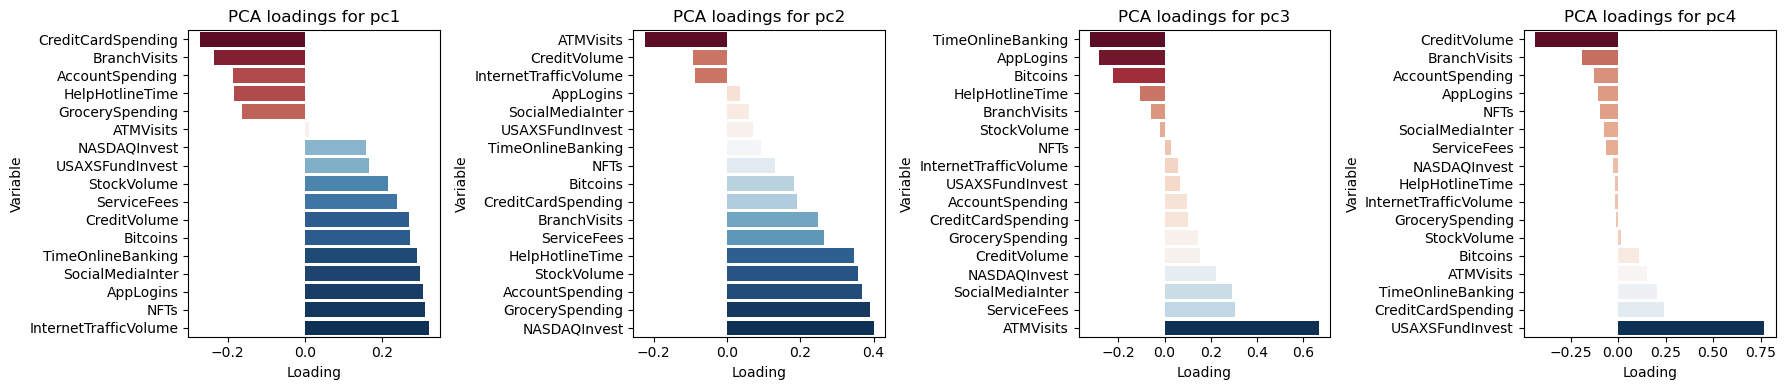

In [17]:
# Visualization of loadings
cols = ['pc1','pc2','pc3','pc4']
fig, axes = plt.subplots(1, len(cols), figsize=(18, 4))

for ax, col in zip(axes, cols):
    sorted_loads = loadings.T[col].sort_values()
    sns.barplot(x=sorted_loads.values, y=sorted_loads.index,ax=ax,hue=sorted_loads.values,legend=False,palette='RdBu')
    ax.set_title(f'PCA loadings for {col}')
    ax.set_xlabel('Loading')
    ax.set_ylabel('Variable')
plt.tight_layout() 
plt.show()

### PCA loading interpretation 
#### pca 1 - tech savvyness + high risk tolerance + heavy internet user + digital banking
* heavy internet/online_banking/socia media user, very high risk tolerance indicated by NFT + Bitcoin investments 

#### pca 2 - proactive interactions with the bank + high in stock investments and spending 
* medium to high risk tolerance indicated by investments in NASDAQ / Stocks
* active in tradional spending like grocery shoppings

#### pca 3 - moderate interactions with the bank + prefer traditional services + medium investments and spending
* traditional banking clients (high atm visits/ service fees) over innovative banking services(banking apps/ online banking)

#### pca 4 - mid-corp stock investment dominates >> bank borrowing + low interactions with the bank + low other investments and spending
* strong preference in medium_sized corp through bank owned funds 
* online banking user

In [18]:
# Cluster profiling on the original data set
df['cluster_pca'] = df_scaled['cluster_pca']
active_cluster_profile = df.groupby('cluster_pca')[active_vars].agg('mean').round(2)
active_cluster_profile

,InternetTrafficVolume,AccountSpending,CreditCardSpending,HelpHotlineTime,GrocerySpending,StockVolume,CreditVolume,BranchVisits,AppLogins,ATMVisits,TimeOnlineBanking,ServiceFees,NASDAQInvest,USAXSFundInvest,SocialMediaInter,Bitcoins,NFTs
cluster_pca,,,,,,,,,,,,,,,,,
0,15.02,3501.77,1900.21,34.91,1200.12,2393.61,149.34,9.99,10.03,4.04,30.04,44.87,3003.14,100.03,2.50,0.0,1.00
1,84.96,552.38,650.28,4.31,264.87,651.03,2499.49,2.31,65.05,6.20,84.99,25.07,400.02,150.23,16.39,0.1,3.03
2,114.99,1296.44,750.66,8.29,650.10,3501.11,1500.71,1.15,90.13,7.10,175.14,75.28,3499.90,2897.03,35.33,0.6,6.47
3,45.01,543.99,1500.42,15.04,349.99,1300.61,149.59,3.58,35.04,4.04,125.10,15.00,350.88,1500.08,4.51,0.0,1.00
4,55.01,1650.07,810.18,16.55,599.92,2400.25,349.97,5.43,74.93,1.51,150.06,15.19,1500.46,300.19,6.49,0.4,3.01
5,55.07,998.15,1008.93,4.07,463.46,1256.67,800.35,3.08,14.95,8.00,65.05,34.73,1499.79,501.86,25.81,0.0,1.89
6,115.02,796.58,549.89,10.28,421.92,5499.04,3500.35,1.61,114.91,3.19,224.96,109.96,4499.83,1049.46,55.42,0.5,9.00


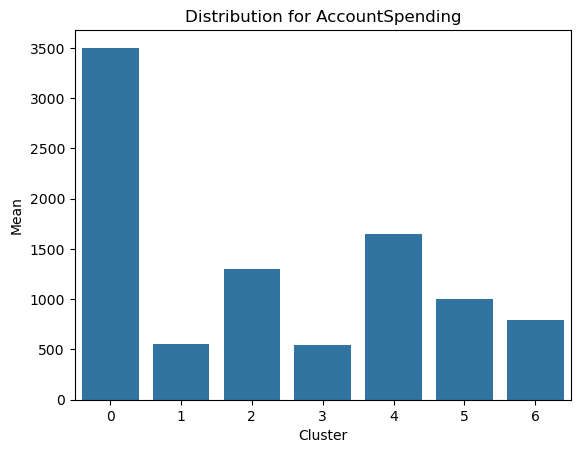

In [19]:
# First examine customers with high spending in the bank
sns.barplot(x=active_cluster_profile.index, y=active_cluster_profile['AccountSpending'])
plt.xlabel('Cluster')
plt.ylabel('Mean')
plt.title(f"Distribution for AccountSpending")
plt.show()

* cluster 0 tops， followed by 4 and 2(account spending)

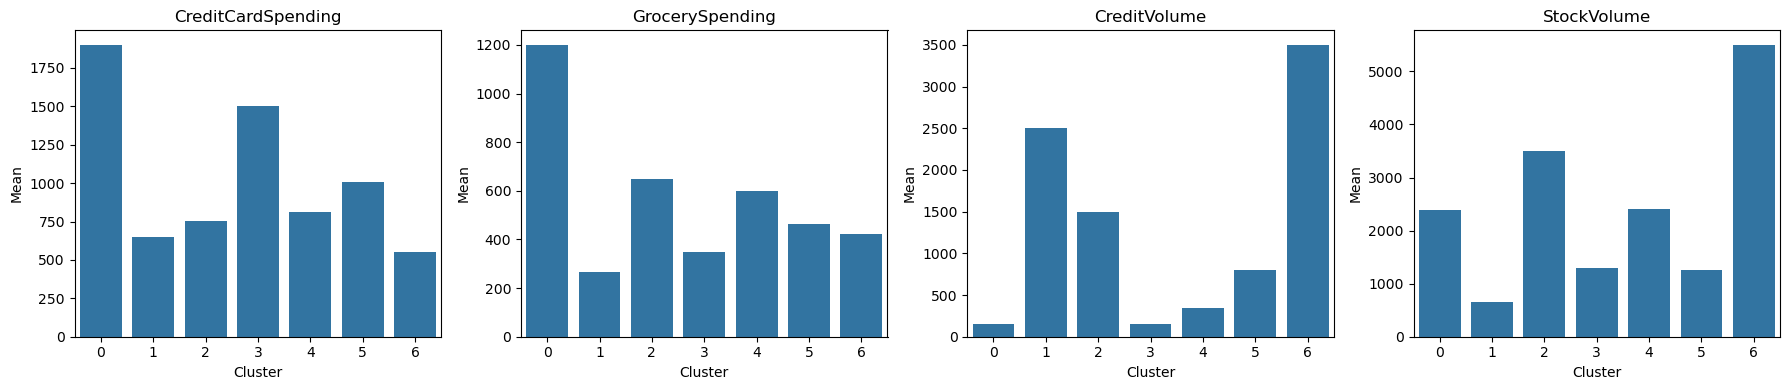

In [20]:
# then examine growth potention: spending + investments
cols = ['CreditCardSpending','GrocerySpending','CreditVolume','StockVolume']
# Create subplots (1 row, 4 columns)
fig, axes = plt.subplots(1, len(cols), figsize=(18, 4))  # adjust width to fit nicely
# Loop through variables and axes together
for ax, col in zip(axes, cols):
    sns.barplot(x=active_cluster_profile.index, y=active_cluster_profile[col], ax=ax)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean')
    ax.set_title(f'{col}')

plt.tight_layout()  # prevent label overlap
plt.show()

### cluster 0 and 6 with the highest potential, followed by cluster 2 and 4
* clusters 6,2,4 top at stock investments 
* clusters 6,1 at bank credits 
* clusters 0,2,4 at grocery spending
### niche  
* cluster 3 at credit card spending 
* cluster 1 at bank credits

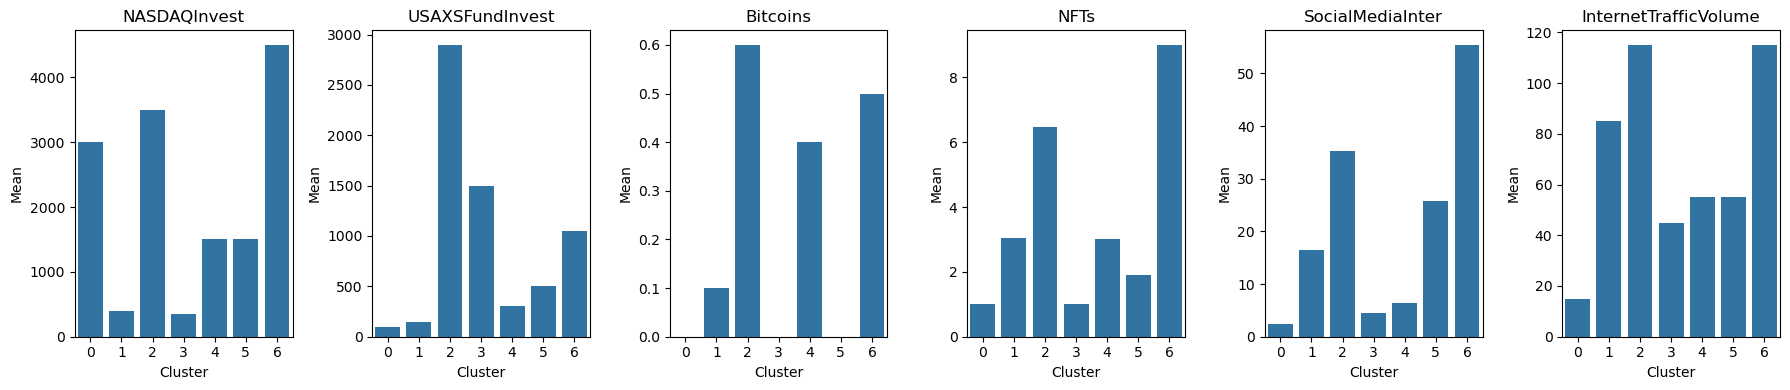

In [21]:
# then examine clusters' investment preferences / risk tolerance / financial sophistication 
# as well as their tech-savvyness
cols = ['NASDAQInvest', 'USAXSFundInvest','Bitcoins','NFTs','SocialMediaInter','InternetTrafficVolume']

fig, axes = plt.subplots(1, len(cols), figsize=(18, 4))  # adjust width to fit nicely

for ax, col in zip(axes, cols):
    sns.barplot(x=active_cluster_profile.index, y=active_cluster_profile[col], ax=ax)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean')
    ax.set_title(f'{col}')

plt.tight_layout()  # prevent label overlap
plt.show()

* clusters 6,2 top at risky investments (NASDAQ, Bitcoins, NFTs) and highly tech-savvy(high social media engagement / heavy internet users)
* clusters 2,3 at medium to high risky investment(USAXSFund)

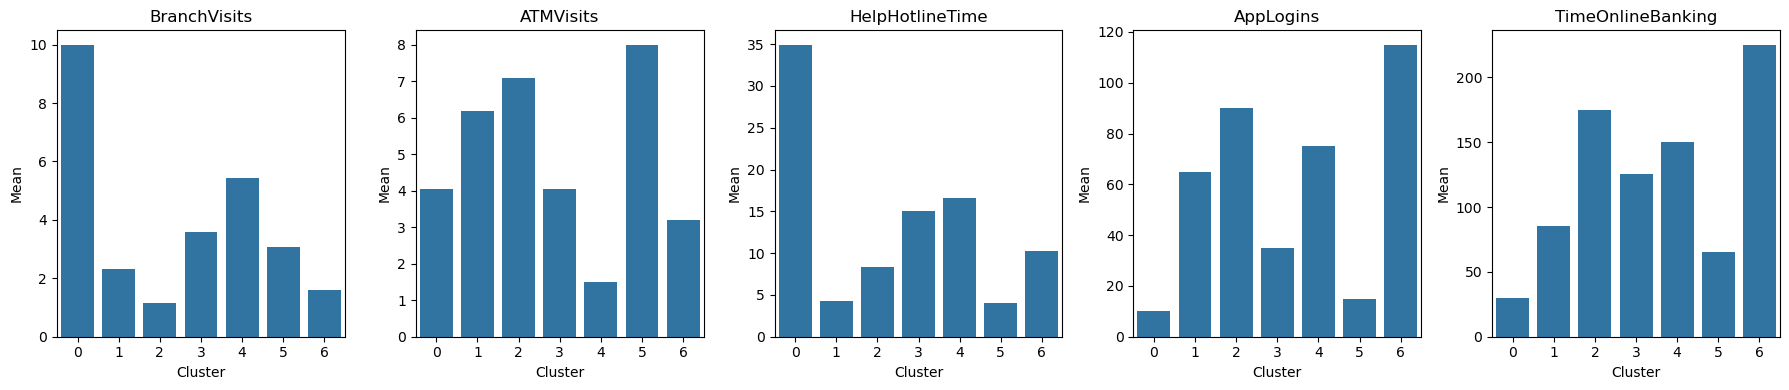

In [22]:
# examine the clusters' preference towards traditional/digital banking services 
cols = ['BranchVisits','ATMVisits','HelpHotlineTime','AppLogins','TimeOnlineBanking']
fig, axes = plt.subplots(1, len(cols), figsize=(18, 4))  # adjust width to fit nicely

for ax, col in zip(axes, cols):
    sns.barplot(x=active_cluster_profile.index, y=active_cluster_profile[col], ax=ax)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean')
    ax.set_title(f'{col}')

plt.tight_layout() 
plt.show()

* clusters 6 and 2 are keen digital banking services users: online banking ++ / app logins ++ while hotline -- and branch visits -- 
* cluster 0 traditional bank users
* cluster 4 in the transition of traditional to digital banking

In [32]:
# cluster profiling on pca_transformed data
cluster_profiles = df_scaled.groupby('cluster_pca')[active_vars].mean()
cluster_profiles_std = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
cluster_profiles_std.to_excel('cluster_profiles_std.xlsx')
cluster_profiles_std

,InternetTrafficVolume,AccountSpending,CreditCardSpending,HelpHotlineTime,GrocerySpending,StockVolume,CreditVolume,BranchVisits,AppLogins,ATMVisits,TimeOnlineBanking,ServiceFees,NASDAQInvest,USAXSFundInvest,SocialMediaInter,Bitcoins,NFTs
cluster_pca,,,,,,,,,,,,,,,,,
0,-1.453635,2.092671,1.763585,2.024139,2.046775,-0.021356,-0.869605,2.008341,-1.215806,-0.360339,-1.366415,-0.024271,0.562517,-0.822552,-0.949249,-0.874295,-0.872376
1,0.419436,-0.754803,-0.753258,-0.848310,-0.964098,-1.075840,0.940257,-0.514115,0.182773,0.576046,-0.551551,-0.587253,-1.072799,-0.772712,-0.233377,-0.493138,-0.199551
2,1.223729,-0.036456,-0.551131,-0.475291,0.276093,0.648823,0.171094,-0.898475,0.820076,0.966293,0.785033,0.840170,0.874590,1.954769,0.742619,1.414750,0.942342
3,-0.650300,-0.762898,0.958573,0.158907,-0.690060,-0.682762,-0.869407,-0.096958,-0.579933,-0.358609,0.043140,-0.873610,-1.103672,0.567650,-0.846044,-0.872777,-0.872376
4,-0.382504,0.304959,-0.431295,0.300177,0.114551,-0.017337,-0.715098,0.510100,0.433815,-1.452674,0.413197,-0.868259,-0.381488,-0.623806,-0.743698,0.651533,-0.204459
5,-0.381093,-0.324432,-0.031077,-0.871023,-0.324753,-0.709348,-0.368259,-0.263136,-1.090678,1.355733,-0.847228,-0.312656,-0.381908,-0.423550,0.251932,-0.858961,-0.575892
6,1.224367,-0.519041,-0.955396,-0.288600,-0.458507,1.857821,1.711017,-0.745757,1.449755,-0.726450,1.523823,1.825880,1.502761,0.120200,1.777817,1.032887,1.782312


In [24]:
# Examine PCA loading strength 
explained_var = pca.explained_variance_ratio_
dominant_pc = loadings.T.abs().idxmax(axis=1)
max_loading = loadings.T.abs().max(axis=1)
weighted_loadings = loadings.T.abs().dot(explained_var)
strong_loading_flags = (loadings.T.abs() >= 0.30).sum(axis=1)  

pca_variable_summary = pd.DataFrame({
    'Dominant PC': dominant_pc,
    'Max Absolute Loading': max_loading,
    'Weighted Loading': weighted_loadings,
    'Stong Loadings Count': strong_loading_flags
}).sort_values(by='Weighted Loading',ascending=False)

print("=== Top Contributing Variables across all PCA Components ===")
pca_variable_summary.head(10)

=== Top Contributing Variables across all PCA Components ===


,Dominant PC,Max Absolute Loading,Weighted Loading,Stong Loadings Count
ServiceFees,pc3,0.305807,0.218135,1
TimeOnlineBanking,pc3,0.323452,0.211664,1
CreditCardSpending,pc1,0.272733,0.210846,0
Bitcoins,pc1,0.273444,0.210305,0
AccountSpending,pc2,0.368618,0.204745,1
NASDAQInvest,pc2,0.400535,0.202449,1
CreditVolume,pc4,0.436813,0.202136,1
StockVolume,pc2,0.357846,0.202042,1
BranchVisits,pc2,0.248760,0.200100,0
NFTs,pc1,0.312839,0.198894,1


In [26]:
# radar chart based on top 10 contributing variables
import plotly.graph_objects as go

vars_to_plot = [
    'ServiceFees','TimeOnlineBanking','CreditCardSpending','Bitcoins','AccountSpending',
    'NASDAQInvest','CreditVolume','StockVolume','BranchVisits','NFTs'
]

fig_act = go.Figure()

# Add a reference line (circle) at r=0
fig_act.add_trace(go.Scatterpolar(
    r=[0]*(len(vars_to_plot) + 1),
    theta=vars_to_plot + [vars_to_plot][0],
    mode='lines',
    line=dict(color='black', width=1.5, dash='dot'),
    name='Baseline (Mean = 0)',
    hoverinfo='skip',
    showlegend=False,
))

for cluster in cluster_profiles_std.index:
    fig_act.add_trace(go.Scatterpolar(
        r = cluster_profiles_std.loc[cluster, vars_to_plot].values,
        theta = vars_to_plot,
        fill = 'toself',
        name = f'Cluster {cluster}',
        opacity = 0.2,           
        line=dict(color='gray')  
    ))


buttons = []
for i, cluster in enumerate(cluster_profiles_std.index):
    opacities = [1.0] + [0.15] * len(cluster_profiles_std.index) 
    opacities[i + 1] = 1.0  

    buttons.append(dict(
        label=f'Cluster {cluster}',
        method='update',
        args=[
            {'opacity': opacities},  
            {'title': f'Profile for Cluster {cluster}'}  
        ]
    ))

# --- Add “Show all” option ---
buttons.insert(0, dict(
    label='Show All',
    method='update',
    args=[
        {'opacity': [1] + [0.6]*len(cluster_profiles_std.index)},
        {'title': 'All Cluster Profiles (Standardized)'}
    ]
))

fig_act.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[-2, 2])),
    title='Cluster profiling (standardized) based on top 10 behavioral/psychographic attributes',
    showlegend=True,
    updatemenus=[dict(
        type='dropdown',
        direction='down',
        x=0.9,
        y=1.15,
        buttons=buttons,
        bgcolor='white',
        bordercolor='gray'
    )]
)

fig_act.show()


In [31]:
# Additonal cluster profiling on the supplementary variables to add interpretability
supp_cluster_profile = df.groupby('cluster_pca')[supplementary_vars].agg('mean').round(2)
cluster_profiles_std.to_excel('supp_cluster_profiles_std.xlsx')
supp_cluster_profile

,Age,Income,HouseholdSize,NumberCars,MortageVolume,CustomerSince,CityAreaSize,MeanCityIncome,MeanCityHousePrize,MeanCityHouseHoldSize,MeanCitySqFtPrice
cluster_pca,,,,,,,,,,,
0,57.97,180029.46,3.49,2.77,149966.17,65.08,120068.72,139990.48,620012.25,3.37,6497.38
1,23.13,37990.76,2.87,0.90,14989.67,2.99,690140.87,249990.57,1849961.79,2.94,8606.07
2,41.87,67991.11,3.44,1.36,124792.47,12.49,450057.90,109774.53,131557.38,4.14,2290.45
3,22.00,45061.94,1.93,1.26,239811.23,3.58,64966.09,139967.48,210031.91,2.40,2291.95
4,29.36,135757.01,2.46,1.51,397925.33,17.93,200045.89,91408.42,528761.00,2.66,4625.49
5,45.03,75063.03,3.43,1.67,349138.24,35.99,453809.54,116192.80,1849751.51,3.89,3667.75
6,37.36,74948.43,2.11,0.36,250262.26,2.52,453890.37,235000.00,450105.52,2.02,6193.53


In [28]:
# standardize this and plot a radar chart
supp_profile_std = (supp_cluster_profile - supp_cluster_profile.mean()) / supp_cluster_profile.std()

In [29]:
fig_supp = go.Figure()

fig_supp.add_trace(go.Scatterpolar(
    r=[0]*(len(supplementary_vars) + 1),
    theta=supplementary_vars + [supplementary_vars][0],
    mode='lines',
    line=dict(color='black', width=1.5, dash='dot'),
    name='Baseline (Mean = 0)',
    hoverinfo='skip',
    showlegend=False
))

for cluster in supp_profile_std.index:
    fig_supp.add_trace(go.Scatterpolar(
        r = supp_profile_std.loc[cluster, supplementary_vars].values,
        theta = supplementary_vars,
        name = f'Cluster {cluster}',
        opacity = 0.2,           
        line=dict(color='darkblue') 
    ))


buttons_supp = []
for i, cluster in enumerate(supp_profile_std.index):
    opacities = [1.0] + [0.15] * len(supp_profile_std.index)
    opacities[i + 1] = 1.0  

    buttons_supp.append(dict(
        label=f'Cluster {cluster}',
        method='update',
        args=[
            {'opacity': opacities},  
            {'title': f'Supplementary Profile for Cluster {cluster}'}  
        ]
    ))

buttons_supp.insert(0, dict(
    label='Show All',
    method='update',
    args=[
        {'opacity': [1.0] + [0.6]*len(supp_profile_std.index)},
        {'title': 'Supplementary Cluster Profiles (Standardized)'}
    ]
))

fig_supp.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[-2, 2])),
    title='Cluster profiling (standardized) based on geographical/demographic attributes',
    showlegend=True,
    updatemenus=[dict(
        type='dropdown',
        direction='down',
        x=0.9,
        y=1.15,
        buttons=buttons,
        bgcolor='white',
        bordercolor='gray'
    )]
)

fig_supp.show()


In [30]:
# write the plotly figures to html files
fig_act.write_html("cluster_profiles_active_vars.html")
fig_supp.write_html("cluster_profiles_supplementary_vars.html")
